# Sap flow prediction Ananlysis

# Introduction
This notebook walks through an analysis of sap flows from maple trees in the US northeast and in Quebec (Canada).  Specifically, the methodology proposed by Houle et al. (2015) is applied to sap flow data made published by Stinson et al. (2019).  The analysis involves predicting whether or not there will be sap collected during a given week using a logistic regression model based on the derived weather features Growing Degree Days (GDD) and freeze-thaw cycles (frthw).  A comparison is made between the precision achieved by Houle et al. (2015) on their original dataset and the current data set using the same modelling parameters.

In [1]:
# Import required pacakages
import numpy as np
import pandas as pd
import os
import altair as alt
from vega_datasets import data

# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server")
alt.renderers.enable('mimetype')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

# Data Preparation
The following code chunk loads the tables which have been created from the data set provided by Stinson et al. (2019) on [ScienceBase](https://www.sciencebase.gov/catalog/item/5d67eacae4b0c4f70cf15be3).  The scripts used to create these tables can be found in the [src](https://github.com/spentelow/sapflow/tree/main/src).

In [2]:
# Load sap measurement data
norm_path = os.path.join(os.pardir, "data", "processed", "stinson2019", "norm_tables")
derived_path = os.path.join(os.pardir, "data", "processed", "stinson2019", "derived_tables")
sap_sugar_df = pd.read_pickle(os.path.join(derived_path, 'sap_sugar_weekly_summary'))

# Load freeze/thaw and growing degree data for a given weather station and associate with a sap measurement site
gdd_frthw = pd.read_pickle(os.path.join(derived_path,'gdd_frthw'))
closest_weather_stn = pd.read_pickle(os.path.join(norm_path, 'closest_weather_stn'))
gdd_frthw = gdd_frthw.merge(closest_weather_stn.reset_index(), how = 'left', on= 'stn_id')
gdd_frthw = gdd_frthw.set_index('datetime')

# Load information on sap measurement sites
location = pd.read_pickle(os.path.join(norm_path, 'location'))
weather_stn = pd.read_pickle(os.path.join(norm_path, 'weather_stn'))

## Locations

The following plot shows the location of the study site for the sap data collection along with the NOAA weather station which has been associated with each site for the purposes of this analysis

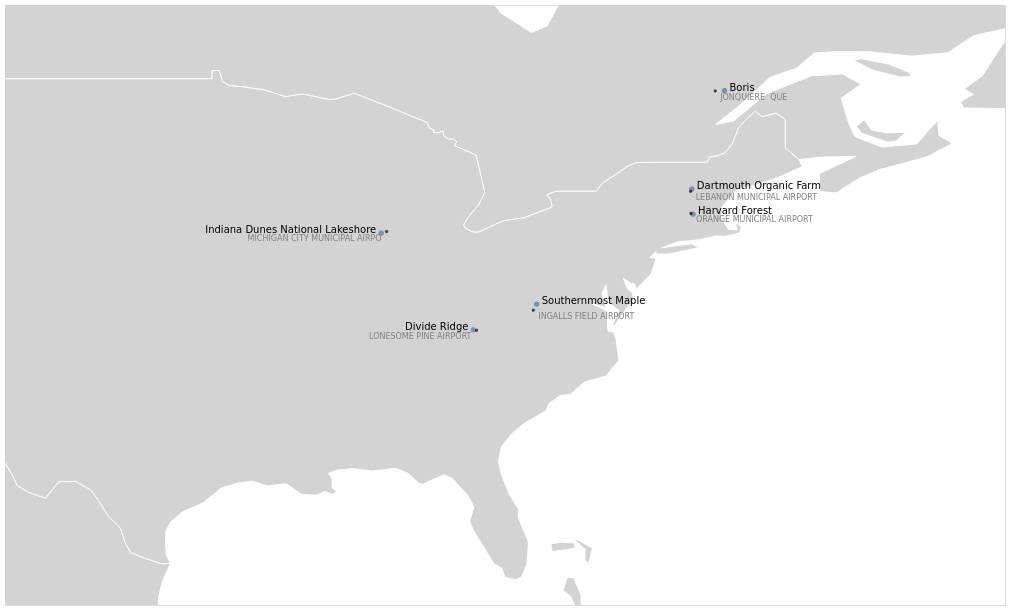

In [3]:
# **TODO**
# Get map showing outlines of Canadian Provinces and US States.
# **TODO**

site_points = alt.Chart(location).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(30)
)

site_labels_east = alt.Chart(location[location.lon>-80]).mark_text(
    align='left',
    baseline='middle',
    dx=5,
    dy=-3
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    text='long_name',
    size= alt.value(10)
)

site_labels_west = alt.Chart(location[location.lon<=-80]).mark_text(
    align='right',
    baseline='middle',
    dx=-5,
    dy=-3
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    text='long_name',
    size= alt.value(10)
)

site_plt = site_points + site_labels_east + site_labels_west

# Weather station points and text

stn_points = alt.Chart(weather_stn).mark_circle(color='black').encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(10)
)

stn_labels_east = alt.Chart(weather_stn[weather_stn.lon>-80]).mark_text(
    align='left',
    baseline='middle',
    dx=5,
    dy=+7,
    color='grey'
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    text='stn_name',
    size= alt.value(8)
)

stn_labels_west = alt.Chart(weather_stn[weather_stn.lon<=-80]).mark_text(
    align='right',
    baseline='middle',
    dx=-5,
    dy=+7,
    color='grey'
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    text='stn_name',
    size= alt.value(8)
)

stn_plt = stn_points + stn_labels_east + stn_labels_west

# states = alt.topo_feature(data.us_10m.url, feature='states')
states = alt.topo_feature(data.world_110m.url, 'countries')

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
)

(background + site_plt + stn_plt).project('equirectangular',
                                        scale=1200,
                                        translate=[2200, 1100]
                                       ).properties(width=1000,height=600)


## Analysis Table Creation

The following code chunk creates a dataframe containing the features required for the prediction model used by Houle et al. (2015).  These features are:
* Cumulative Growing Degree Days (GDD)
* Cumulative freeze-thaw cycles (frthw)
* Whether sap flow occurred during a given week sap flow (0 = no, 1 = yes)

More information on these features is provided in the following section.  Additional featuers are also given in the dataframe `full_sap` including the measurement dates and locations.

In [4]:
# Create a dataframe (`full_sap`) which contains information on both sap flow and the growing degree days and freeze/thaw cycles for all tap/year combinations

full_sap = pd.DataFrame(
    columns=[
        "tap_id",
        "date_from",
        "date_to",
        "weekly_sugarwt",
        "weekly_sap",
        "site",
        "cumGDD",
        "cum_frthw",
        "sap_binary",
    ]
)

for site in sap_sugar_df.site.unique():
    sap_sugar_site = sap_sugar_df[sap_sugar_df.site == site]
    for tap in sap_sugar_site.tap_id.unique():
        sap_sugar_tap = sap_sugar_site[sap_sugar_site.tap_id == tap]
        for year in sap_sugar_tap.date_to.dt.year.unique():
            sap_sugar_year = sap_sugar_tap[sap_sugar_tap.date_to.dt.year == year].drop(
                columns=["site"]
            )

            # Merge weather from local station with sap measurements for a given tap and year
            sap_sugar_year = sap_sugar_year.merge(
                gdd_frthw[(gdd_frthw.site == site) & (gdd_frthw.index.year == year)],
                how="right",
                left_on=["date_to"],
                right_index=True,
            )

            # Add missing dates, tap_ids to df
            sap_sugar_year.loc[:, "date_from"] = sap_sugar_year.loc[
                :, "date_to"
            ] - pd.DateOffset(6)
            sap_sugar_year["weather_datetime"] = sap_sugar_year.date_to
            sap_sugar_year["tap_id"] = sap_sugar_year["tap_id"].fillna(tap)

            # Fill in missing 0 values
            sap_sugar_year.loc[:, "weekly_sugarwt"] = sap_sugar_year.loc[
                :, "weekly_sugarwt"
            ].fillna(0)
            sap_sugar_year.loc[:, "weekly_sap"] = sap_sugar_year.loc[
                :, "weekly_sap"
            ].fillna(0)

            #             # For future implementation
            #             # Add total weekly freeze-thaw cycles column (week ending on date 'date_to')
            #             sap_sugar_year.loc[:, "weekly_frthw"] = sap_sugar_year.loc[:, "cum_frthw"] - sap_sugar_year.loc[:, "cum_frthw"].shift(6)
            sap_sugar_year = sap_sugar_year.rename(columns={'frthw':'cum_frthw'})
            

            # Create row indicating if there is (1) or is not (0) sap flow in a given week (week ending on 'date_to')
            sap_sugar_year["sap_binary"] = sap_sugar_year["weekly_sap"].apply(
                lambda x: 0 if ((pd.isnull(x)) | (x == 0)) else 1
            )

            full_sap = full_sap.append(sap_sugar_year)

# Coerce sap_binary column to numpy.int64 for subesquent analyses
full_sap.sap_binary = full_sap.sap_binary.astype("int")

# Drop columns not used in current analysis and reset index
full_sap = full_sap.drop(columns=['weekly_sugarwt', 'weekly_sap','mean_airt'])
full_sap.reset_index(inplace=True, drop=True)

In [5]:
full_sap.head()

,tap_id,date_from,date_to,site,cumGDD,cum_frthw,sap_binary,stn_id,GDD,weather_datetime
0,DOF1A,2013-12-26,2014-01-01,DOF,0.0,0.0,0,726116-94765,0.0,2014-01-01
1,DOF1A,2013-12-27,2014-01-02,DOF,0.0,0.0,0,726116-94765,0.0,2014-01-02
2,DOF1A,2013-12-28,2014-01-03,DOF,0.0,0.0,0,726116-94765,0.0,2014-01-03
3,DOF1A,2013-12-29,2014-01-04,DOF,0.0,0.0,0,726116-94765,0.0,2014-01-04
4,DOF1A,2013-12-30,2014-01-05,DOF,0.0,0.0,0,726116-94765,0.0,2014-01-05


# Analysis

## Logistic Regression Model

Houle et al. (2015) created a logistic regression model to predict the presence or absence of maple syrup production in a given week.  The following linear function was developed based on their measured data:

$$ P = -5.09 + 0.722F - 0.014F^2 - 0.07G$$

Where:

$P$ = Predictor of whether there will or will not be sap flowing in a given week (variable is labelled 'Production' in Houle et al., 2015)

$F$ = Cumulative number of freeze/thaw events since the beginning of the year (January 1st).  A freeze/thaw event is counted if the temperature rises above a given threshold ($T_{thresh}$) and drops below it again.  A threshold of 3&deg;C has been used as in Houle et al., 2015.  The temperature measurements used to derive this feature were generally taken every 15 minutes.

$G$ = Cumulative number of growing degree days since the beginning of the year (January 1st) using a 5&deg;C base temperature ($T_{base}$).  Each day, the maximum air temperature ($T_{max}$is extracted and, if it is above the $T_{base}$, a value of $T_{base} - T_{max}$ is added to the running total of growing degree days ($G$).

Passing $P$ into a sigmoid function and applying a threshold of 0.51, we end up with a prediction of whether there will or will not be sap flow in a given week.

$$\hat{Y} = \begin{cases}
1 & \text{if} \ \frac{1}{1+e^{-P}} \geq 0.51 \\
0 & \text{if} \ \frac{1}{1+e^{-P}} < 0.51
\end{cases}
$$

*Note that in the subsequent tables, $S$ is used to denote the output of the sigmoid function $\frac{1}{1+e^{-P}}$.*

The code chunks below manually compute the predictions of for $P$ for the data provided by Stinson et al. (2019) and stores the full result in a dataframe called `LR_table`.  A summary of the prediction results for each tap and year are stored in `LR_summary` including whether a prediction was a true positive, true negative, false positive, or false negative and the precision of the predictions with respect to weeks when sap flow did occur (`precision_1`) and for weeks when sap flow did not occur (`precision_0`). 

In [6]:
# Coefficients of linear model created by Houle 2015 and threshold for predicting 'True' for sap flow from logistic function
houle_coeff = np.array([-5.09, 0.733, -0.014, -0.07])
houle_thresh = 0.51

# Create dataframe of parameters required for Houle 2015 analysis
LR_table = full_sap[
    ["site", "tap_id", "date_from", "date_to", "cum_frthw", "cumGDD", "sap_binary"]
]
LR_table = LR_table.rename(
    columns={"cum_frthw": "F", "cumGDD": "G", "sap_binary": "Y"}
)

LR_table["F2"] = LR_table.F ** 2  # Add F**2 column
LR_table["bias"] = 1  # Add bias column


# Calculations to generate weekly sapflow predictions based on model by Houle et al., 2015
LR_table.loc[:, "P"] = LR_table[["bias", "F", "F2", "G"]] @ (houle_coeff)
LR_table.loc[:, "S"] = 1 / (1 + np.exp(-LR_table["P"])
)  # Add intermediate sigmoid output column 'S'
LR_table.loc[:, "Y_hat"] = (LR_table["S"] > houle_thresh).astype(
    "int"
)  # Threshold determined by Houle 2015


LR_table["jd"] = LR_table["date_to"].dt.dayofyear
LR_table["year"] = LR_table["date_to"].dt.year

# Add columns to count number of true positives, false positives, false negatives, and true negatives
LR_table["tp"] = LR_table.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_hat == 1) else 0, axis=1
)
LR_table["fp"] = LR_table.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_hat == 1) else 0, axis=1
)
LR_table["fn"] = LR_table.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_hat == 0) else 0, axis=1
)
LR_table["tn"] = LR_table.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_hat == 0) else 0, axis=1
)

In [7]:
LR_table.head()

,site,tap_id,date_from,date_to,F,G,Y,F2,bias,P,S,Y_hat,jd,year,tp,fp,fn,tn
0,DOF,DOF1A,2013-12-26,2014-01-01,0.0,0.0,0,0.0,1,-5.09,0.00612,0,1,2014,0,0,0,1
1,DOF,DOF1A,2013-12-27,2014-01-02,0.0,0.0,0,0.0,1,-5.09,0.00612,0,2,2014,0,0,0,1
2,DOF,DOF1A,2013-12-28,2014-01-03,0.0,0.0,0,0.0,1,-5.09,0.00612,0,3,2014,0,0,0,1
3,DOF,DOF1A,2013-12-29,2014-01-04,0.0,0.0,0,0.0,1,-5.09,0.00612,0,4,2014,0,0,0,1
4,DOF,DOF1A,2013-12-30,2014-01-05,0.0,0.0,0,0.0,1,-5.09,0.00612,0,5,2014,0,0,0,1


In [8]:
# Calculate summary of performance of Houle et al., 2015 model in terms of precision of prediction for weeks with sap flow (`precision_1`) 
# and prediction of weeks without sap flow (`precision_0`).
LR_summary = (
    LR_table[["site", "tap_id", "year", "tn", "fp", "fn", "tp"]]
    .groupby(["tap_id", "year", "site"])
    .sum()
)
LR_summary["precision_1"] = LR_summary.tp / (LR_summary.tp + LR_summary.fn)
LR_summary["precision_0"] = LR_summary.tn / (LR_summary.tn + LR_summary.fp)
LR_summary = LR_summary.reset_index()
LR_summary = LR_summary.merge(
    location.reset_index()[["site", "short_name", "state_province"]],
    on="site",
    how="left",
)
LR_summary["loc"] = LR_summary.short_name + ", " + LR_summary.state_province

In [9]:
LR_summary.head()

,tap_id,year,site,tn,fp,fn,tp,precision_1,precision_0,short_name,state_province,loc
0,DOF10A,2014,DOF,265,62,21,17,0.447368,0.810398,Dartmouth,NH,"Dartmouth, NH"
1,DOF10A,2015,DOF,322,3,4,36,0.900000,0.990769,Dartmouth,NH,"Dartmouth, NH"
2,DOF10A,2016,DOF,290,28,32,16,0.333333,0.911950,Dartmouth,NH,"Dartmouth, NH"
3,DOF10A,2017,DOF,290,40,14,21,0.600000,0.878788,Dartmouth,NH,"Dartmouth, NH"
4,DOF10B,2014,DOF,265,68,21,11,0.343750,0.795796,Dartmouth,NH,"Dartmouth, NH"


## Logistic Regression Predictions

The following plot illustrates the predictions of the logistic regression model for a single tap ('QC1A' from the Boris/Quebuec site) for a single year (2015).  The plot displays the output of the sigmoid function ($S$) for the values of the linear regression ($P$)  The threshold $S$ value to predict sap in a given week was 0.51 as specified by Houle et al (2015) and is plotted as a dashed black line.

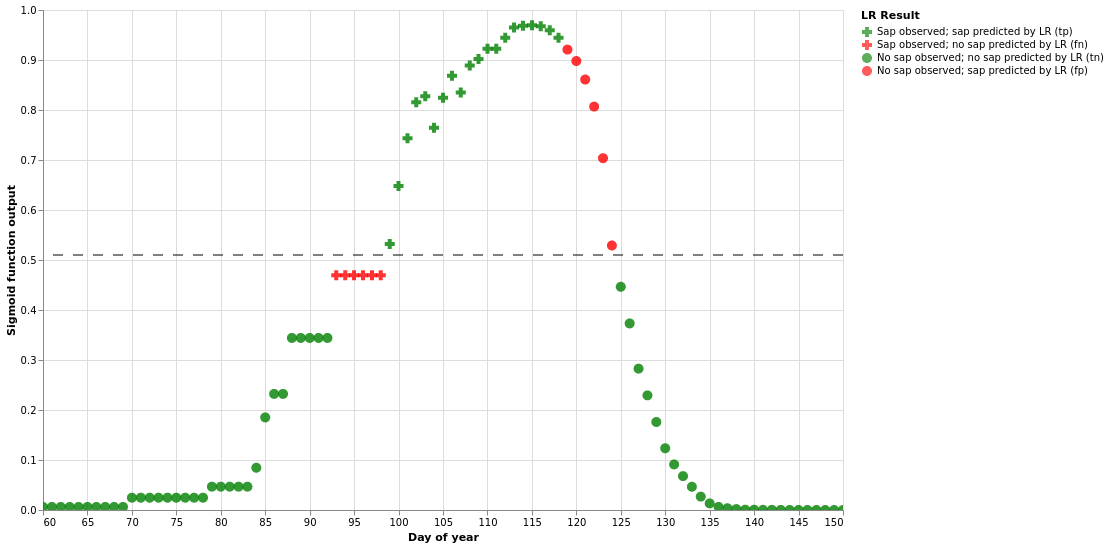

In [10]:
# Creates sample plot demonstrating output of sigmoid function over the course of a year.

sample_sigmoid = LR_table[
    (LR_table.site == "QC")
    & (LR_table.date_to.dt.year == 2015)
    & (LR_table.tap_id == "QC1A")
]

sample_sigmoid = sample_sigmoid.rename(
    columns={
        "tn": "No sap observed; no sap predicted by LR (tn)",
        "fp": "No sap observed; sap predicted by LR (fp)",
        "fn": "Sap observed; no sap predicted by LR (fn)",
        "tp": "Sap observed; sap predicted by LR (tp)",
    }
)

sample_sigmoid = (
    sample_sigmoid.reset_index()
    .melt(
        id_vars="index",
        value_vars=[
            "Sap observed; sap predicted by LR (tp)",
            "Sap observed; no sap predicted by LR (fn)",
            "No sap observed; no sap predicted by LR (tn)",
            "No sap observed; sap predicted by LR (fp)",
        ],
    )
    .merge(
        sample_sigmoid.reset_index()[["index", "S", "P", "Y", "Y_hat", "jd"]],
        on="index",
    )
)

sample_sigmoid = sample_sigmoid[sample_sigmoid.value == 1]


domain_pred = [
    "Sap observed; sap predicted by LR (tp)",
    "Sap observed; no sap predicted by LR (fn)",
    "No sap observed; no sap predicted by LR (tn)",
    "No sap observed; sap predicted by LR (fp)",
]

sigmoid_plt = (
    alt.Chart(sample_sigmoid)
    .mark_point(size=100, stroke=None, opacity=0.8)
    .encode(
        alt.X("jd", title="Day of year", scale=alt.Scale(domain=[60, 150])),
        alt.Y("S", title="Sigmoid function output"),
        fill=alt.Fill(
            "variable",
            title="LR Result",
            scale=alt.Scale(domain=domain_pred, range=["green", "red", "green", "red"]),
        ),
        shape=alt.Shape(
            "variable",
            scale=alt.Scale(
                domain=domain_pred, range=["cross", "cross", "circle", "circle"]
            ),
        ),
    )
    .interactive()
)


sigmoid_plt = sigmoid_plt + alt.Chart(pd.DataFrame({"ht": [houle_thresh]})).mark_rule(
    color="black",
    strokeDash=[10,10]
).encode(y="ht")

sigmoid_plt.properties(width=800, height=500).configure_legend(labelLimit=0)

## Precision of Predictions
The following plot shows the precision of the predictions generated with the model proposed by Houle et al. (2015) for each tap and each year.  Houle et al (2015) stated that, 'The global model accurately predicted 83% of the production weeks and 95% of the non-production weeks.'  Assuming that these values represent the precision with respect to production weeks and with respect to non-production weeks, respectively, these values have been plotted as dashed red lines for reference.

In [11]:
# Generate plots showing prediction precision by site (red lines for comparison to precision reported by Houle et al., 2015)

houle_means = pd.DataFrame({"prec_1": [0.83], "prec_0": [0.95]})

# Create plot of precision for weeks with sap production
prec_1_plt = (
    alt.Chart(LR_summary)
    .mark_boxplot()
    .encode(
        y=alt.Y("precision_1", title="Precision of prediction of weeks with sap flow"),
        x=alt.X("loc", title="Site Location"),
        #         color = alt.Color("loc", legend=None)
    )
)

prec_1_plt = prec_1_plt + alt.Chart(houle_means).mark_rule(
    color="red", strokeDash=[10, 10]
).encode(y="prec_1")

# Create plot of precision for weeks without sap production
prec_0_plt = (
    alt.Chart(LR_summary)
    .mark_boxplot()
    .encode(
        y=alt.Y(
            "precision_0", title="Precision of prediction of weeks without sap flow"
        ),
        x=alt.X("loc", title="Site Location"),
        #         color = alt.Color("loc", legend=None)
    )
)
prec_0_plt = prec_0_plt + alt.Chart(houle_means).mark_rule(
    color="red", strokeDash=[10, 10]
).encode(y="prec_0")


width = 500

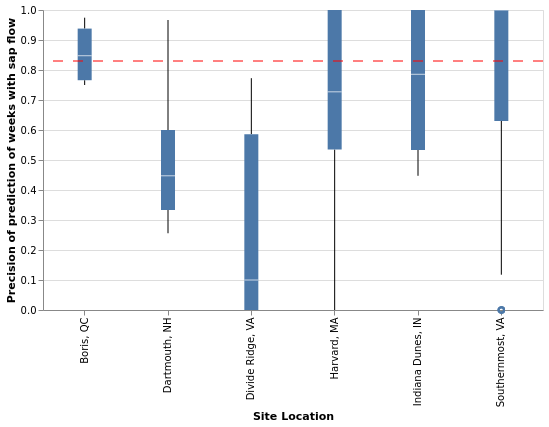

In [12]:
prec_1_plt.properties(width=width)

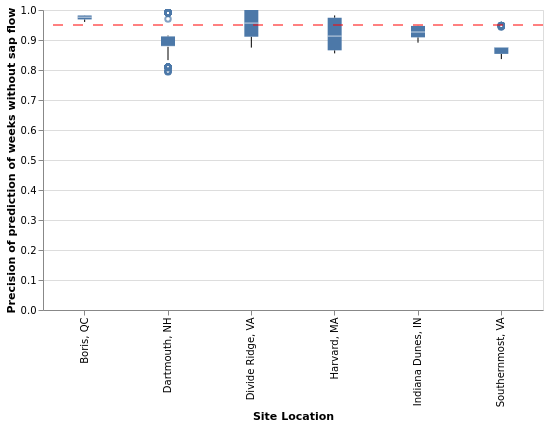

In [13]:
prec_0_plt.properties(width=width)

## Site Specific Logistic Regression
Using the same model set up as Houle et al. (2015), separate logistic regression models were fit for each Site to determine the improvement in the model predictions when the model was fit to local data.  The resulting model precisions are plotted against the precision of predictions using the model coefficients suggested by Houle et al. (2015).  Note that the parameters which were fit in these site specific models were the parameters of the regression equation ($\beta_0, \beta_1, \beta_2,$ and $\beta_3$):

$$ P = \beta_0 + \beta_1F + \beta_2F^2 + \beta_3G$$

where Houle et al. (2015) used the following values:
$$ \beta_0 = -5.09 \\
\beta_1 = 0.722 \\
\beta_2 = -0.014 \\
\beta_3 = 0.07$$

Note that the features of the model were not adjusted as part of the site-specific refitting.  In particular, the freeze-thaw threshold temperatures and the growing-degree base temperature were not changed from the values used by Houle et al. (2015).

In [14]:
log_regs = dict()
site_spec_reg_prec = pd.DataFrame(columns=LR_table.site.unique().tolist())
test_list = []  # Create list of all test data

for site in LR_table.site.unique():
    X = LR_table[LR_table.site == site][["F", "F2", "G"]]
    y = np.ravel(LR_table[LR_table.site == site][["Y"]])

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.8,
        random_state=123,
        stratify=LR_table[LR_table.site == site].tap_id,
    )
    log_regs[site] = LogisticRegression()
    log_regs[site].fit(X_train, y_train)
    site_spec_reg_prec[site] = [precision_score(y_test, log_regs[site].predict(X_test))]
    
    # Populate list of all training data
    test_list += X_test.index.to_list()

In [15]:
for site in LR_table.site.unique():
    LR_table.loc[LR_table.site==site,['_','Y_logreg']] = log_regs[site].predict_proba(LR_table.loc[LR_table.site==site, ["F", "F2", "G"]])

# Use same regression threshold as Houle et al. (2015)
LR_table.loc[:,'Y_logreg'] = (LR_table.loc[:,'Y_logreg']>houle_thresh).astype('int')
LR_table.drop(columns=['_'],inplace=True)

In [16]:
# Add columns to count number of true positives, false positives, false negatives, and true negatives
LR_table["tp_lr"] = LR_table.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_logreg == 1) else 0, axis=1
)
LR_table["fp_lr"] = LR_table.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_logreg == 1) else 0, axis=1
)
LR_table["fn_lr"] = LR_table.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_logreg == 0) else 0, axis=1
)
LR_table["tn_lr"] = LR_table.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_logreg == 0) else 0, axis=1
)

In [17]:
# Calculate summary of performance of Houle et al., 2015 model in terms of precision of prediction for weeks with sap flow (`precision_1`) 
# and prediction of weeks without sap flow (`precision_0`).  Only test data is included in the precision values.
LR_summary.loc[:,["tn_lr", "fp_lr", "fn_lr", "tp_lr"]] = (
    LR_table.loc[test_list,["site", "tap_id", "year", "tn_lr", "fp_lr", "fn_lr", "tp_lr"]]
    .groupby(["tap_id", "year", "site"])
    .sum()
).reset_index()
LR_summary["precision_1_lr"] = LR_summary.tp_lr / (LR_summary.tp_lr + LR_summary.fn_lr)
LR_summary["precision_0_lr"] = LR_summary.tn_lr / (LR_summary.tn_lr + LR_summary.fp_lr)

In [18]:
# Generate plots showing prediction precision by site (red lines for comparison to precision reported by Houle et al., 2015

LR_prec = (
    LR_summary.reset_index()
    .melt(
        id_vars="index",
        value_vars=["precision_1", "precision_1_lr", "precision_0", "precision_0_lr"],
        value_name="prec_model",
    )
    .merge(LR_summary.reset_index(), on="index")
)

LR_prec["model"] = np.where(
    (LR_prec.variable == "precision_1") | (LR_prec.variable == "precision_0"),
    "Houle",
    "Site Specific",
)

prec_1_plt_lr = (
    alt.Chart(
        LR_prec[
            (LR_prec["variable"] == "precision_1")
            | (LR_prec["variable"] == "precision_1_lr")
        ]
    )
    .mark_rule(color="red")
    .encode(y="houle")
    .mark_boxplot()
    .encode(
        y=alt.Y("prec_model", title="Precision of prediction of weeks with sap flow"),
        x=alt.X("model", title="Model"),
        color=alt.Color("model", title="Model"),
        column=alt.Column("site", title="Site"),
    )
)

prec_0_plt_lr = (
    alt.Chart(
        LR_prec[
            (LR_prec["variable"] == "precision_0")
            | (LR_prec["variable"] == "precision_0_lr")
        ]
    )
    .mark_boxplot()
    .encode(
        y=alt.Y(
            "prec_model", title="Precision of prediction of weeks with no sap flow"
        ),
        x=alt.X("model", title="Model"),
        color=alt.Color("model", title="Model"),
        column=alt.Column("site", title="Site"),
    )
)


width = 100

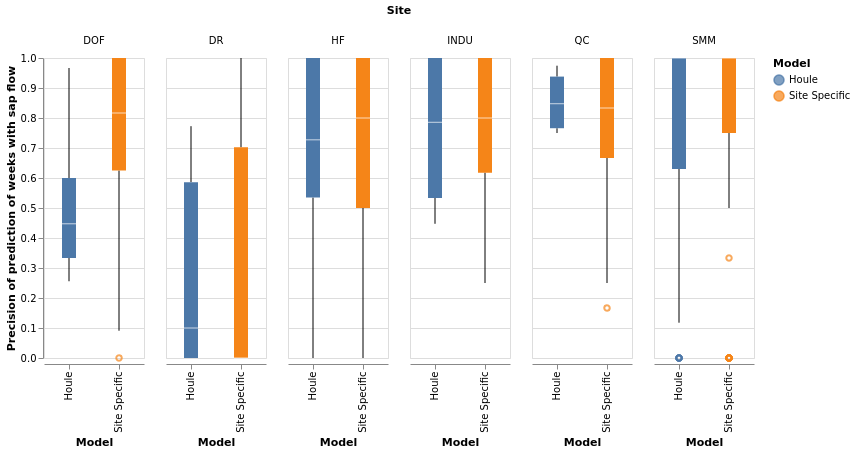

In [19]:
prec_1_plt_lr.properties(width=width)

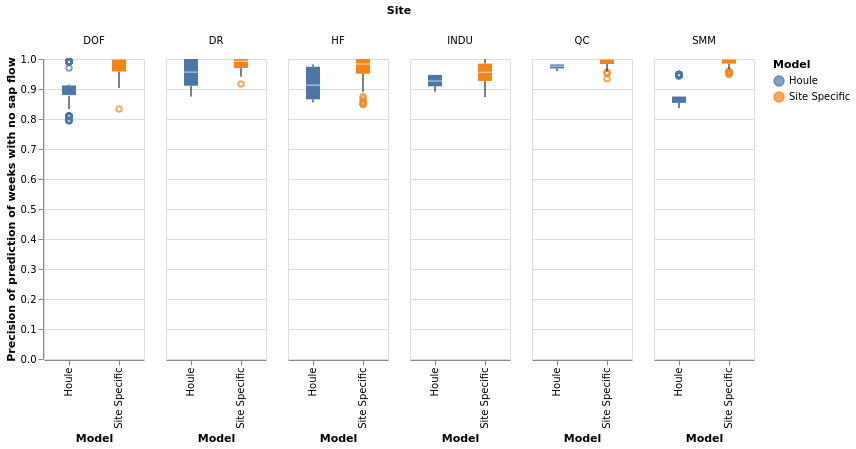

In [20]:
prec_0_plt_lr.properties(width=width)

# Results

## Overall Precision
Houle et al. (2015) stated that their model, 'accurately predicted 83% of the production weeks and 95% of the non-production weeks.'  It is assumed that these values represent the precision with respect to production weeks and with respect to non-production weeks, respectively.  The table below compares the global precision of the model fit by Houle et al. (2015) on their original data, the model fit by Houle et al. (2015) on the data from Stinson et al. (2019), and a series of models fit to each site location using the data from Stinson et al. (2019).  Note that only the training data used to fit the site specific models is  excluded from the precision calculations on the site specific models.

In [21]:
models = ["Houle on Stinson Data", "Site Specific on Stinson Data", "Houle Original"]
precision_type = ["With Sap", "Without"]

column_index = pd.MultiIndex.from_product(
    [models, precision_type], names=["Model:", "Precision for weeks:"]
)
overall_prec = pd.DataFrame(
    columns=column_index,
    index=LR_table.site.unique().tolist(),
)
overall_prec.index.name = "Site"

overall_prec.loc[:, ("Houle on Stinson Data", "With Sap")] = (
    LR_summary.groupby(["site"]).mean().precision_1
)
overall_prec.loc[:, ("Houle on Stinson Data", "Without")] = (
    LR_summary.groupby(["site"]).mean().precision_0
)
overall_prec.loc[:, ("Site Specific on Stinson Data", "With Sap")] = (
    LR_summary.groupby(["site"]).mean().precision_1_lr
)
overall_prec.loc[:, ("Site Specific on Stinson Data", "Without")] = (
    LR_summary.groupby(["site"]).mean().precision_0_lr
)
overall_prec.loc[
    :, [("Houle Original", "With Sap"), ("Houle Original", "Without")]
] = ""

overall_prec.loc["Overall", :] = [
    LR_summary.mean().precision_1,
    LR_summary.mean().precision_0,
    LR_summary.mean().precision_1_lr,
    LR_summary.mean().precision_0_lr,
    0.83,
    0.95,
]

In [22]:
overall_prec.round(decimals=2)

Model:               Houle on Stinson Data          \
Precision for weeks:              With Sap Without   
Site                                                 
DOF                                   0.54    0.89   
DR                                    0.26    0.95   
HF                                    0.71    0.91   
INDU                                  0.76    0.93   
QC                                    0.86    0.97   
SMM                                   0.74    0.88   
Overall                               0.68    0.92   

Model:               Site Specific on Stinson Data         Houle Original  \
Precision for weeks:                      With Sap Without       With Sap   
Site                                                                        
DOF                                           0.75    0.98                  
DR                                            0.32    0.98                  
HF                                            0.74    0.97                  
INDU                                          0.77    0.95                  
QC                                            0.79    0.99                  
SMM                                           0.80    0.99                  
Overall                                       0.74    0.98           0.83   

Model:                        
Precision for weeks: Without  
Site                          
DOF                           
DR                            
HF                            
INDU                          
QC                            
SMM                           
Overall                 0.95

## Model Comparsion
From the table above, we see that the overall precision attained by Houle et al. (2015) on their original data set was not replicated when applying their method to the data sets from Stinson et al. (2019).  In particular, the precision of predicting weeks without sap production was substantially lower (0.68 vs 0.83) when the model was applied to the data from Stinson et al. (2019).  Refitting the regression coefficients for the model to the data sets from each site resulted in some improvement in model performance.  In this case, the site specific models achieved a higher precision of prediction for the weeks without sap production than did the Houle et al. (2015) on the original data set.  The precision of prediction of the weeks with sap production, however, remained lower in the site specific model than in the original work of Houle et al. (2015).